# Boulder Watershed Demo

## Background
### ATL03
The ATL03 data set (https://nsidc.org/data/atl03/versions/6) contains height above the WGS 84 ellipsoid (ITRF2014 reference frame), latitude, longitude, and time for all photons downlinked by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory. The ATL03 product was designed to be a single source for all photon data and ancillary information needed by higher-level ATLAS/ICESat-2 products. As such, it also includes spacecraft and instrument parameters and ancillary data not explicitly required for ATL03.

### ATL06
The ATL06 data set (https://nsidc.org/data/atl06/versions/6) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were also acquired by the ATLAS instrument on board ICESat-2.

## The goal of this demo
Process ATL03 data from the Boulder Watershed region and produce a customized ATL06 elevation dataset.

### What is demonstrated

* The `icesat2.atl06p` Application Programming Interface (API) is used to perform a SlideRule parallel processing request of the Boulder Watershed region
* The `matplotlib` and `geopandas` packages are used to plot the data returned by SlideRule

### Points of interest

This is a simple notebook showing how a region of interest (the Boulder Watershed region) can be processed by SlideRule and the results analyzed using pandas DataFrames and Matplotlib.

In [1]:
import logging
import geopandas as gpd
import matplotlib.pyplot as plt
from sliderule import icesat2
import matplotlib.cm as cm

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io")
# Configure Region of Interest (provide 4 corner points)
region = [ {"lon":-105.82971551223244, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 39.81983728534918} ]

Client (version (4, 12, 3)) is out of date with the server (version (4, 15, 1))


## Execute ATL06 Algorithm using SlideRule

In [3]:
%%time

# Build ATL06 Request
parms = {
    "poly": region, # polygon defining region of interest
    "srt": icesat2.SRT_LAND, # surface type
    "cnf": icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection
    "ats": 10.0, # minimum along track spread
    "cnt": 10,   # minimum photon count in segment
    "len": 40.0, # length of each extent in meters
    "res": 20.0  # step distance for successive extents in meters
}

# Request ATL06 Data
gdf = icesat2.atl06p(parms)

# Display Statistics (What are these, and why are they important??)
print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
print("Cycles: {}".format(gdf["cycle"].unique()))
print("Received {} elevations".format(len(gdf)))

Reference Ground Tracks: [554 973 996  28 531  51]
Cycles: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Received 404306 elevations
CPU times: user 10.1 s, sys: 342 ms, total: 10.4 s
Wall time: 4min 4s


## Plot Region

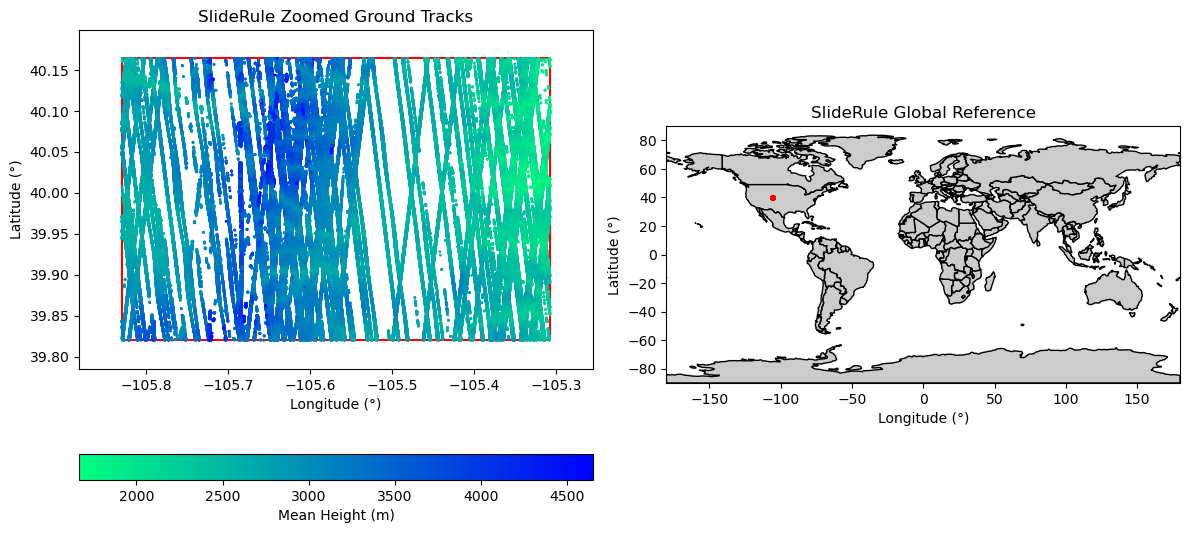

In [5]:
# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,(ax1,ax2) = plt.subplots(num=None, ncols=2, figsize=(12, 6))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
gdf.plot(ax=ax1, column=gdf["h_mean"], cmap='winter_r', s=1.0, zorder=3)
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlabel('Longitude (°)')
ax1.set_ylabel('Latitude (°)')

# Add color bar
sm = plt.cm.ScalarMappable(cmap='winter_r', norm=plt.Normalize(vmin=gdf["h_mean"].min(), vmax=gdf["h_mean"].max()))
sm._A = []  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax1, orientation='horizontal', label='Mean Height (m)')

# Plot SlideRule Global View
ax2.set_title("SlideRule Global Reference")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip") # updated link
world.plot(ax=ax2, color='0.8', edgecolor='black')
gdf.plot(ax=ax2, marker='o', color='red', markersize=2.5, zorder=3)
ax2.set_xlim(-180,180)
ax2.set_ylim(-90,90)
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('Longitude (°)')
ax2.set_ylabel('Latitude (°)')

# Show Plot
plt.tight_layout()